<a href="https://colab.research.google.com/github/Raiden-Makoto/BQML-Projects/blob/main/Subway/SubwayGIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Geospatial Analytics with Google BigQuery

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.colab import userdata
project = userdata.get('PROJ_NAME')

In [3]:
from google.cloud import bigquery
# Replace 'your-gcp-project-id' with your actual Google Cloud Project ID.
# You can find your project ID in the Google Cloud Console.
# Explicitly set the location to 'US' to access the public dataset.
client = bigquery.Client(project=project, location='US')

In [4]:
import pandas as pd

## Task 1: Investigate the Dataset
We will be using the New York City subway dataset. Our table of interest will be `new_york_subway.stations`. We first investigate the schema, then perform some basic queries.

In [7]:
schema_query = "SELECT * FROM `bigquery-public-data.new_york_subway.stations`"
schema = client.query(schema_query).to_dataframe()
print("Available columns", schema.columns)
schema.head()

Available columns Index(['station_id', 'complex_id', 'gtfs_stop_id', 'division', 'line',
       'station_name', 'borough_name', 'daytime_routes', 'structure',
       'north_direction_label', 'south_direction_label', 'station_lat',
       'station_lon', 'station_geom'],
      dtype='object')


,station_id,complex_id,gtfs_stop_id,division,line,station_name,borough_name,daytime_routes,structure,north_direction_label,south_direction_label,station_lat,station_lon,station_geom
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Queens,N W,Elevated,None,Manhattan,40.775036,-73.912034,POINT(-73.912034 40.775036)
1,2,2,R03,BMT,Astoria,Astoria Blvd,Queens,N W,Elevated,Ditmars Blvd,Manhattan,40.770258,-73.917843,POINT(-73.917843 40.770258)
2,3,3,R04,BMT,Astoria,30 Av,Queens,N W,Elevated,Astoria - Ditmars Blvd,Manhattan,40.766779,-73.921479,POINT(-73.921479 40.766779)
3,4,4,R05,BMT,Astoria,Broadway,Queens,N W,Elevated,Astoria - Ditmars Blvd,Manhattan,40.761820,-73.925508,POINT(-73.925508 40.76182)
4,5,5,R06,BMT,Astoria,36 Av,Queens,N W,Elevated,Astoria - Ditmars Blvd,Manhattan,40.756804,-73.929575,POINT(-73.929575 40.756804)


In [9]:
print("Unique Lines:", schema['line'].unique())

Unique Lines: ['Astoria' 'Broadway - Brighton' 'Broadway' 'Manhattan Bridge' '4th Av'
 'Sea Beach / West End / Culver / Brighton' 'West End' 'Sea Beach'
 'Jamaica' 'Myrtle Av' 'Canarsie' 'Franklin Shuttle' '8th Av - Fulton St'
 'Concourse' '6th Av - Culver' 'Liberty Av' 'Rockaway' '63rd St'
 'Queens Blvd' 'Queens - Archer' 'Crosstown' 'Broadway - 7Av' 'Clark St'
 'Eastern Pky' 'Nostrand' 'Pelham' 'Jerome Av' 'Lexington Av'
 'Lenox - White Plains Rd' 'Dyre Av' 'Flushing' 'Lexington - Shuttle'
 'Second Av' 'Staten Island']


We can use this to do some basic, non-geospatial queries. For example, suppose we want to know all stations on the `6th Av - Culver line`, and which trains stop there.

In [10]:
culver_query = """
SELECT
    station_name,
    borough_name,
    daytime_routes
FROM `bigquery-public-data.new_york_subway.stations`
WHERE line = '6th Av - Culver'
"""
culver_stations = client.query(culver_query).to_dataframe()
culver_stations.head()

,station_name,borough_name,daytime_routes
0,W 4 St,Manhattan,B D F M
1,57 St,Manhattan,F
2,47-50 Sts - Rockefeller Ctr,Manhattan,B D F M
3,42 St - Bryant Pk,Manhattan,B D F M
4,34 St - Herald Sq,Manhattan,B D F M


We can also see how many stations there are in each borough.

In [14]:
station_query = """
SELECT borough_name, COUNT(station_name) AS num_stations
FROM `bigquery-public-data.new_york_subway.stations`
GROUP BY borough_name
ORDER BY num_stations DESC
"""
station_counts = client.query(station_query).to_dataframe()
station_counts.head()

,borough_name,num_stations
0,Brooklyn,169
1,Manhattan,153
2,Queens,83
3,Bronx,70
4,Staten Island,21


## Task 2: Distance Queries
We can use the `station_geom` field in the `stations` table to get the coordinates of a station. Using the function `ST_DISTANCE`, which calculates the distance between two `GEOGRAPHY` values, assuming a spherical earth, we can perform queries such as finding the closest stations to a given location.

Suppose we want to know what stations are closest to 23 Cornelia Street. We use `ST_GEOGPOINT` to represent a location in latitude and longitude. Note that the argument input order is `longitude, latitude`.

In [15]:
target_loc = (40.73160160095787, -74.00225289325259)

In [19]:
distance_query1 = f"""
SELECT
    station_name,
    daytime_routes,
    ST_DISTANCE(
        station_geom,
        ST_GEOGPOINT({target_loc[1]}, {target_loc[0]})
    ) AS distance
FROM `bigquery-public-data.new_york_subway.stations`
ORDER BY distance ASC
LIMIT 5
"""
closest_stations = client.query(distance_query1).to_dataframe()
closest_stations.head()

,station_name,daytime_routes,distance
0,W 4 St,B D F M,169.247531
1,W 4 St,A C E,169.247531
2,Christopher St - Sheridan Sq,1,209.766532
3,Houston St,1,455.702162
4,Spring St,C E,610.608086


## Task 3: Contains Queries
Suppose we didn't know beforehand which stations were in each borough. All we have is a polygon sketch of the borough boundary. How can we determine this information?

We can use `ST_WITHIN(geography_1, geography_2)`! It returns True if no point of geography_1 is outside of geography_2 and the interiors of geography_1 and geography_2 intersect.

In [21]:
station_geom = "SELECT * FROM `bigquery-public-data.new_york_subway.geo_nyc_borough_boundaries`"
polygons = client.query(station_geom).to_dataframe()
polygons

,borough_code,borough_name,borough_area,borough_len,borough_geom
0,3,Brooklyn,1.937593e+09,738745.835869,MULTIPOLYGON(((-73.9199006427004 40.5996005225...
1,5,Staten Island,1.623756e+09,325960.634597,MULTIPOLYGON(((-74.0531403682111 40.5777027155...
2,2,Bronx,1.186612e+09,462958.188213,MULTIPOLYGON(((-73.8888514849633 40.7987063289...
3,1,Manhattan,6.366027e+08,361212.479734,MULTIPOLYGON(((-73.9213375241928 40.8008521075...
4,4,Queens,3.045885e+09,904390.137335,MULTIPOLYGON(((-73.8099705940606 40.6000675373...


In [23]:
contains_query = """
SELECT
    s.station_id,
    s.station_name,
    b.borough_name,
    s.station_geom
FROM `bigquery-public-data.new_york_subway.stations` AS s
JOIN `bigquery-public-data.new_york_subway.geo_nyc_borough_boundaries` AS b
ON ST_WITHIN(s.station_geom, b.borough_geom)
ORDER BY
    b.borough_name,
    s.station_name
"""
boroughs = client.query(contains_query).to_dataframe()
boroughs

,station_id,station_name,borough_name,station_geom
0,391,138 St - Grand Concourse,Bronx,POINT(-73.929849 40.813224)
1,435,149 St - Grand Concourse,Bronx,POINT(-73.926718 40.81841)
2,390,149 St - Grand Concourse,Bronx,POINT(-73.927351 40.818375)
3,219,161 St - Yankee Stadium,Bronx,POINT(-73.925651 40.827905)
4,389,161 St - Yankee Stadium,Bronx,POINT(-73.925831 40.827994)
...,...,...,...,...
491,519,Richmond Valley,Staten Island,POINT(-74.229141 40.519631)
492,501,St George,Staten Island,POINT(-74.073643 40.643748)
493,503,Stapleton,Staten Island,POINT(-74.075162 40.627915)
494,502,Tompkinsville,Staten Island,POINT(-74.074835 40.636949)


We can save the code as a table and connect to Looker Studio to create a map visualization that shows the distribution of stations across boroughs. We can also use markers to display invidividual stations.

In [ ]:
import pandas_gbq

# Define the full table ID
table_id = f"{project}.new_york_subway.station_boroughs"

# Define the schema for BigQuery table, specifying GEOGRAPHY for station_geom
table_schema = [
    {'name': 'station_id', 'type': 'INTEGER'},
    {'name': 'station_name', 'type': 'STRING'},
    {'name': 'borough_name', 'type': 'STRING'},
    {'name': 'station_geom', 'type': 'GEOGRAPHY'}
]

# Convert 'station_id' column to integer type, as it's currently a string
boroughs['station_id'] = boroughs['station_id'].astype(int)

# Save the DataFrame to BigQuery using pandas_gbq with the defined schema
pandas_gbq.to_gbq(
    boroughs,
    table_id,
    project_id=project,
    if_exists='replace',
    table_schema=table_schema
)

print(f"DataFrame successfully saved to BigQuery table: {table_id}")

Now that the data is saved in a BigQuery table, you can connect to it using Looker Studio to create map visualizations, showing the distribution of stations across boroughs and individual station locations.

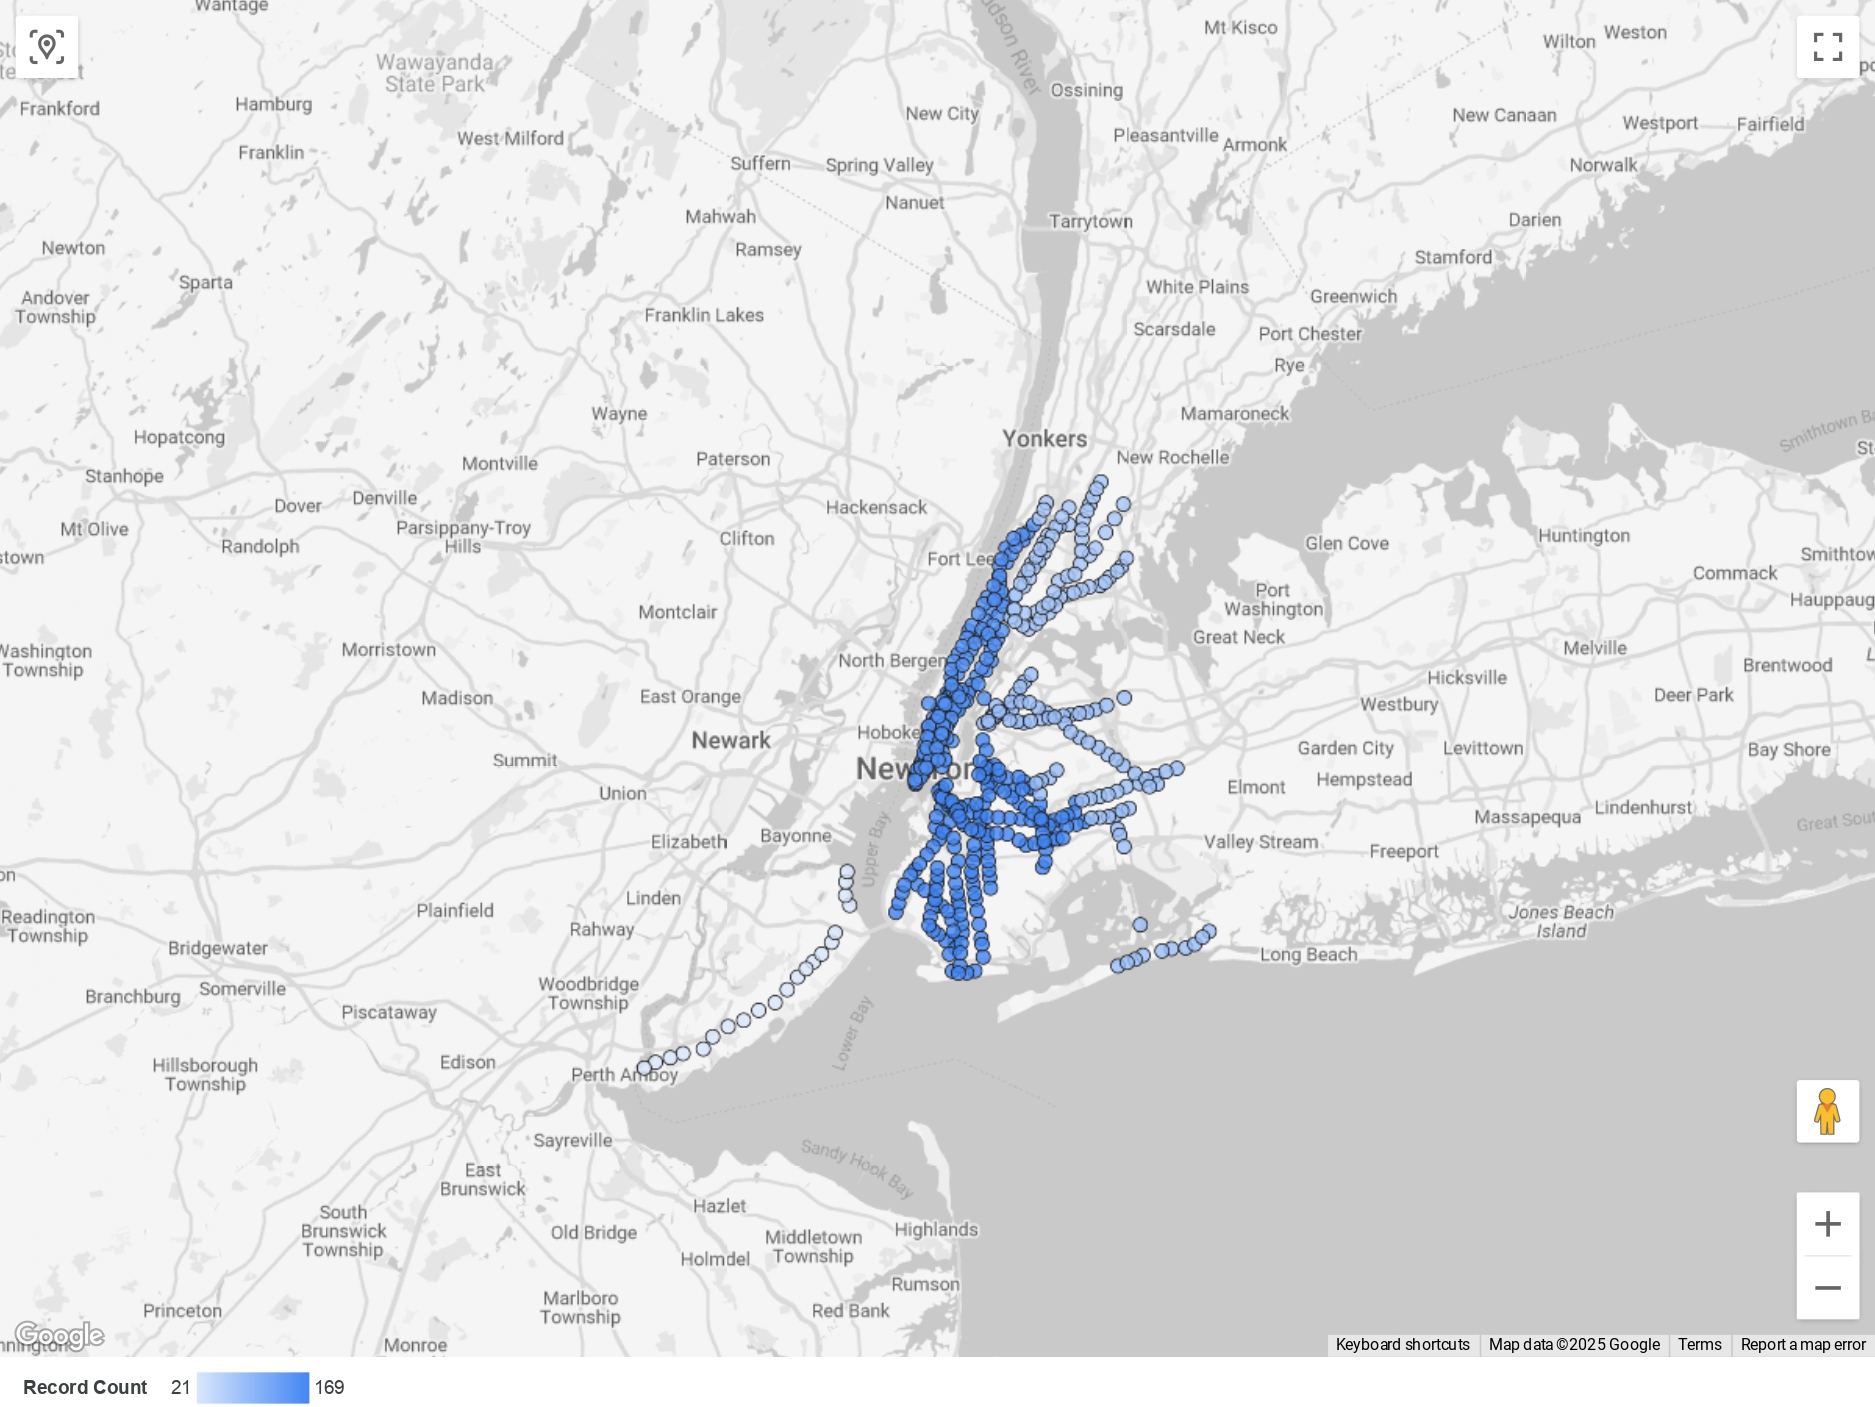

## Task 4: Advanced Queries
We can also perform density analysis to identify clusters of stations. For example, if we want to see how many stations are within 500 meters of each other, we can use `ST_CLUSTERDBSCAN(geography_column, epsilon, minimum_geographies)`. This performs DBSCAN clustering on a column of geographies, with radius around a core value `epsilon` and `minimum_geographies` geographis per cluster.

In [28]:
cluster = """
WITH clustered_stations AS (
SELECT
    station_id,
    station_name,
    station_geom,
    ST_CLUSTERDBSCAN(station_geom, 500, 3) OVER() AS cluster_id
FROM `bigquery-public-data.new_york_subway.stations`
)
SELECT
    cluster_id,
    COUNT(*) AS num_stations,
    ARRAY_AGG(station_name) AS station_names
FROM clustered_stations
WHERE cluster_id IS NOT NULL
GROUP BY cluster_id
ORDER BY num_stations DESC
"""
clusters = client.query(cluster).to_dataframe()
clusters.head()

,cluster_id,num_stations,station_names
0,4,39,"[Prince St, Canal St, Canal St, City Hall, Cor..."
1,1,23,"[5 Av/59 St, 57 St - 7 Av, 49 St, Times Sq - 4..."
2,5,20,"[Court St, Jay St - MetroTech, DeKalb Av, Atla..."
3,2,19,"[34 St - Herald Sq, 28 St, 23 St, 8 Av, 6 Av, ..."
4,7,8,"[Alabama Av, Broadway Jct, Chauncey St, Bushwi..."


We can see that some clusters have over 20 stations within 500 meters of each other!

We can also use `ST_CONVEXHULL` to calculate the boundary polygons around clustered stations

In [30]:
convexhull_query = """
WITH clustered AS (
SELECT
    ST_CLUSTERDBSCAN(station_geom, 500, 3) OVER() AS cluster_id,
    station_geom,
    station_name
FROM `bigquery-public-data.new_york_subway.stations`
)
SELECT
    cluster_id,
    COUNT(*) AS num_stations,
    ST_CONVEXHULL(ST_UNION_AGG(station_geom)) AS cluster_boundary
FROM clustered
WHERE cluster_id IS NOT NULL
GROUP BY cluster_id
"""
convexhull = client.query(convexhull_query).to_dataframe()
convexhull.head()

,cluster_id,num_stations,cluster_boundary
0,0,5,"POLYGON((-73.967967 40.762526, -73.967258 40.7..."
1,1,23,"POLYGON((-73.989735 40.757308, -73.987495 40.7..."
2,2,19,"POLYGON((-74.002578 40.739777, -74.000201 40.7..."
3,3,5,"POLYGON((-73.990568 40.735736, -73.99073 40.73..."
4,4,39,"POLYGON((-74.013783 40.707513, -74.014065 40.7..."


In [ ]:
import pandas_gbq

# Define the full table ID
table_id_convexhull = f"{project}.new_york_subway.station_convexhulls"

# Define the schema for BigQuery table, specifying GEOGRAPHY for cluster_boundary
table_schema_convexhull = [
    {'name': 'cluster_id', 'type': 'INTEGER'},
    {'name': 'num_stations', 'type': 'INTEGER'},
    {'name': 'cluster_boundary', 'type': 'GEOGRAPHY'}
]

# Convert 'cluster_id' column to integer type, as it's an integer in the schema
convexhull['cluster_id'] = convexhull['cluster_id'].astype(int)

# Save the DataFrame to BigQuery using pandas_gbq with the defined schema
pandas_gbq.to_gbq(
    convexhull,
    table_id_convexhull,
    project_id=project,
    if_exists='replace',
    table_schema=table_schema_convexhull
)

print(f"DataFrame successfully saved to BigQuery table: {table_id_convexhull}")

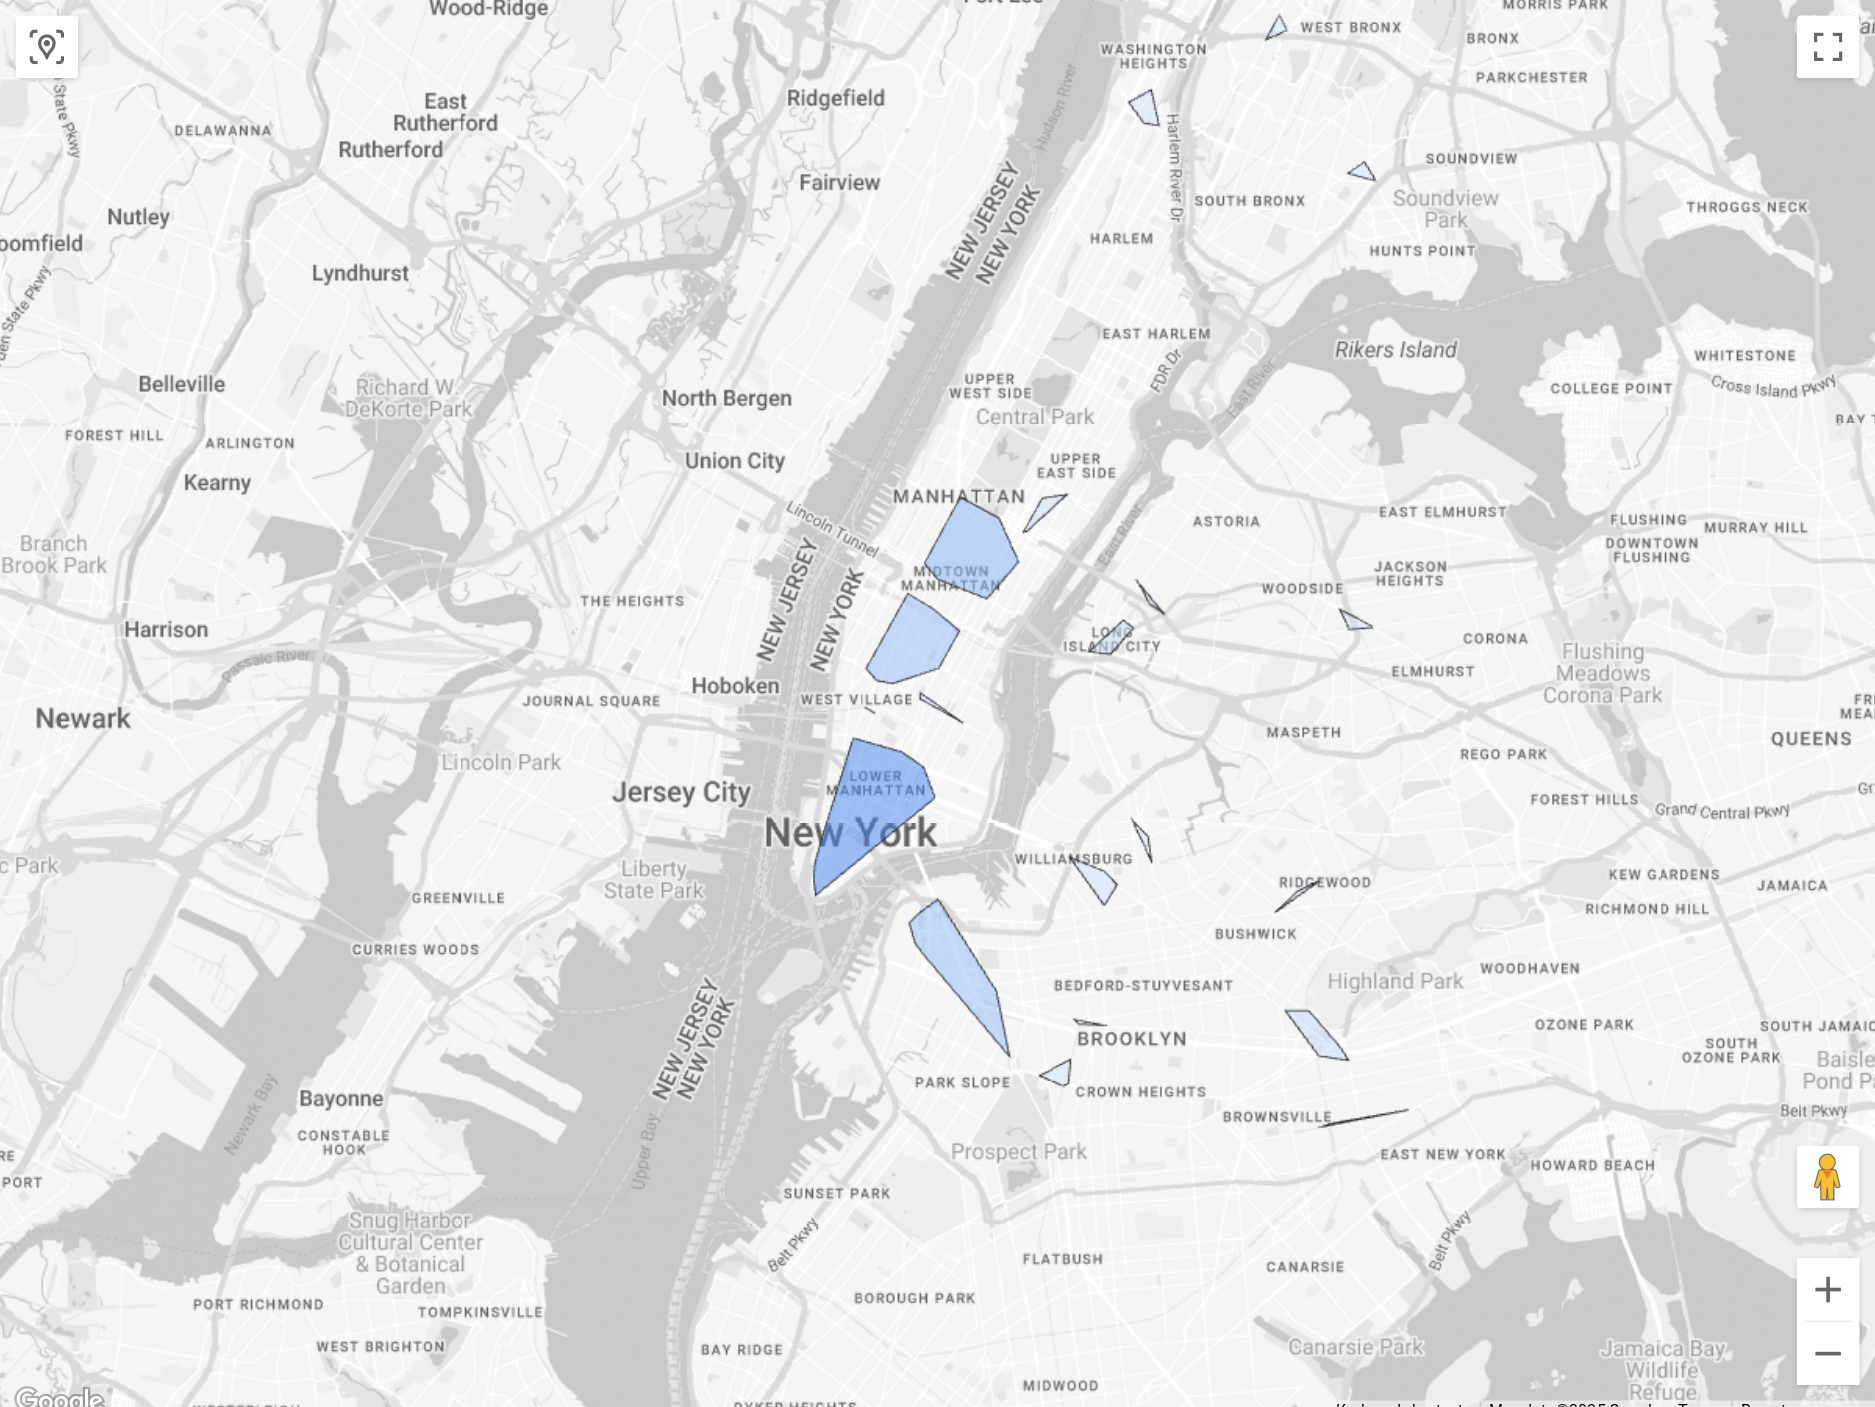 We can now connect to the `station_convexhulls` table in Looker Studio to visualize the boundaries of the station clusters.